## Importar librerias

In [20]:
import kagglehub
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.inspection import PartialDependenceDisplay


import warnings
warnings.filterwarnings("ignore")

## Importacion data

In [2]:
path = kagglehub.dataset_download("emonsharkar/python-learning-and-exam-performance-dataset")
df = pd.read_csv(os.path.join(path, os.listdir(path)[0]))
df.head(    )

student_id  age   country prior_programming_experience  weeks_in_course  \
0           1   54  Pakistan                     Beginner               12   
1           2   44   Nigeria                          NaN               15   
2           3   30     India                 Intermediate                5   
3           4   23   Nigeria                     Beginner                4   
4           5   36        UK                          NaN                3   

   hours_spent_learning_per_week  practice_problems_solved  \
0                           12.2                        60   
1                           14.2                        52   
2                            7.7                        71   
3                            5.6                        64   
4                            3.5                        62   

   projects_completed  tutorial_videos_watched  uses_kaggle  \
0                   1                       24            0   
1                   1                       32            0   
2                   1                       43            0   
3                   2                       40            1   
4                   1                       47            1   

   participates_in_discussion_forums  debugging_sessions_per_week  \
0                                  1                            4   
1                                  0                            5   
2                                  0                            6   
3                                  0                            3   
4                                  0                            3   

   self_reported_confidence_python  final_exam_score  passed_exam  
0                               10              53.8            0  
1                                7              31.9            0  
2                                3              59.4            0  
3                               10              58.8            0  
4                                7              24.8            0

In [3]:
df.shape

(3000, 15)

In [4]:
df.isnull().sum() # prior_programming_experience tiene data un importante N nulo 

student_id                              0
age                                     0
country                                 0
prior_programming_experience         1062
weeks_in_course                         0
hours_spent_learning_per_week           0
practice_problems_solved                0
projects_completed                      0
tutorial_videos_watched                 0
uses_kaggle                             0
participates_in_discussion_forums       0
debugging_sessions_per_week             0
self_reported_confidence_python         0
final_exam_score                        0
passed_exam                             0
dtype: int64

In [5]:
df.isnull().sum()/len(df)*100 # Un tercio de la data es nula, por lo que se opta por eliminar

student_id                            0.0
age                                   0.0
country                               0.0
prior_programming_experience         35.4
weeks_in_course                       0.0
hours_spent_learning_per_week         0.0
practice_problems_solved              0.0
projects_completed                    0.0
tutorial_videos_watched               0.0
uses_kaggle                           0.0
participates_in_discussion_forums     0.0
debugging_sessions_per_week           0.0
self_reported_confidence_python       0.0
final_exam_score                      0.0
passed_exam                           0.0
dtype: float64

In [6]:
df.nunique()
#De la tabla se concluye que efectivamente student_id es un id(unico para cada registro) y se deberá eliminar
#Adicional se visualizan 3 variables dicotomicas entre ellas la objetivo "passed exam"

student_id                           3000
age                                    39
country                                10
prior_programming_experience            3
weeks_in_course                        15
hours_spent_learning_per_week         157
practice_problems_solved               51
projects_completed                     10
tutorial_videos_watched                43
uses_kaggle                             2
participates_in_discussion_forums       2
debugging_sessions_per_week            16
self_reported_confidence_python        10
final_exam_score                      750
passed_exam                             2
dtype: int64

In [7]:
df.info() # Solo 2 variables categoricas por defecto en el DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   student_id                         3000 non-null   int64  
 1   age                                3000 non-null   int64  
 2   country                            3000 non-null   object 
 3   prior_programming_experience       1938 non-null   object 
 4   weeks_in_course                    3000 non-null   int64  
 5   hours_spent_learning_per_week      3000 non-null   float64
 6   practice_problems_solved           3000 non-null   int64  
 7   projects_completed                 3000 non-null   int64  
 8   tutorial_videos_watched            3000 non-null   int64  
 9   uses_kaggle                        3000 non-null   int64  
 10  participates_in_discussion_forums  3000 non-null   int64  
 11  debugging_sessions_per_week        3000 non-null   int64

In [8]:
df.describe(include= "all").T

count unique       top  freq       mean  \
student_id                         3000.0    NaN       NaN   NaN     1500.5   
age                                3000.0    NaN       NaN   NaN     35.327   
country                              3000     10    Brazil   339        NaN   
prior_programming_experience         1938      3  Beginner  1034        NaN   
weeks_in_course                    3000.0    NaN       NaN   NaN      8.121   
hours_spent_learning_per_week      3000.0    NaN       NaN   NaN   7.035267   
practice_problems_solved           3000.0    NaN       NaN   NaN  59.983667   
projects_completed                 3000.0    NaN       NaN   NaN   2.001333   
tutorial_videos_watched            3000.0    NaN       NaN   NaN  39.896667   
uses_kaggle                        3000.0    NaN       NaN   NaN   0.400667   
participates_in_discussion_forums  3000.0    NaN       NaN   NaN   0.498333   
debugging_sessions_per_week        3000.0    NaN       NaN   NaN   4.973333   
self_reported_confidence_python    3000.0    NaN       NaN   NaN      5.566   
final_exam_score                   3000.0    NaN       NaN   NaN  43.318267   
passed_exam                        3000.0    NaN       NaN   NaN   0.177333   

                                          std   min     25%     50%      75%  \
student_id                         866.169729   1.0  750.75  1500.5  2250.25   
age                                 11.302182  16.0    26.0    36.0     45.0   
country                                   NaN   NaN     NaN     NaN      NaN   
prior_programming_experience              NaN   NaN     NaN     NaN      NaN   
weeks_in_course                      4.275019   1.0     5.0     8.0     12.0   
hours_spent_learning_per_week        2.936134   0.0     5.0     7.0      9.0   
practice_problems_solved             7.713056  35.0    55.0    60.0     65.0   
projects_completed                   1.395701   0.0     1.0     2.0      3.0   
tutorial_videos_watched              6.263258  19.0    35.0    40.0     44.0   
uses_kaggle                          0.490115   0.0     0.0     0.0      1.0   
participates_in_discussion_forums    0.500081   0.0     0.0     0.0      1.0   
debugging_sessions_per_week          2.236729   0.0     3.0     5.0      6.0   
self_reported_confidence_python      2.885207   1.0     3.0     6.0      8.0   
final_exam_score                    17.376666   0.0    30.9    43.1     55.6   
passed_exam                          0.382014   0.0     0.0     0.0      0.0   

                                      max  
student_id                         3000.0  
age                                  54.0  
country                               NaN  
prior_programming_experience          NaN  
weeks_in_course                      15.0  
hours_spent_learning_per_week        17.1  
practice_problems_solved             87.0  
projects_completed                    9.0  
tutorial_videos_watched              63.0  
uses_kaggle                           1.0  
participates_in_discussion_forums     1.0  
debugging_sessions_per_week          17.0  
self_reported_confidence_python      10.0  
final_exam_score                    100.0  
passed_exam                           1.0

## Analisis exploratorio

### Variables continuas

In [9]:
var_num = [col for col in df.select_dtypes("number").columns if df[col].nunique()>2 and col != "student_id"]

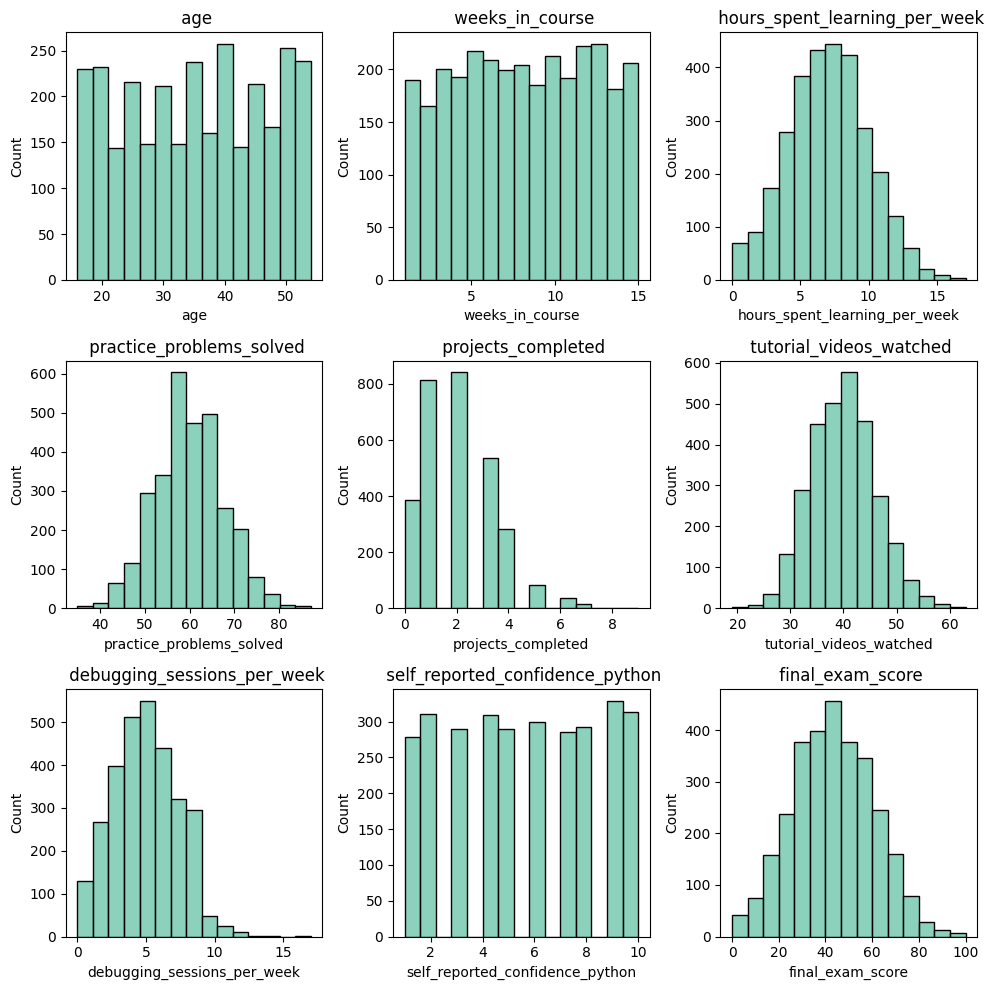

In [10]:

def histplot_df(df, vars, target = None):
    sns.set_palette("Set2")
    fig, axes = plt.subplots(3,3, figsize = (10,10))
    axes = axes.flatten()
    

    for i, col in enumerate(var_num):
        axes[i].set_title(f" {col}")
        sns.histplot(df, x = col, ax = axes[i], bins = 15, hue = target)

    plt.tight_layout()

histplot_df(df, var_num)

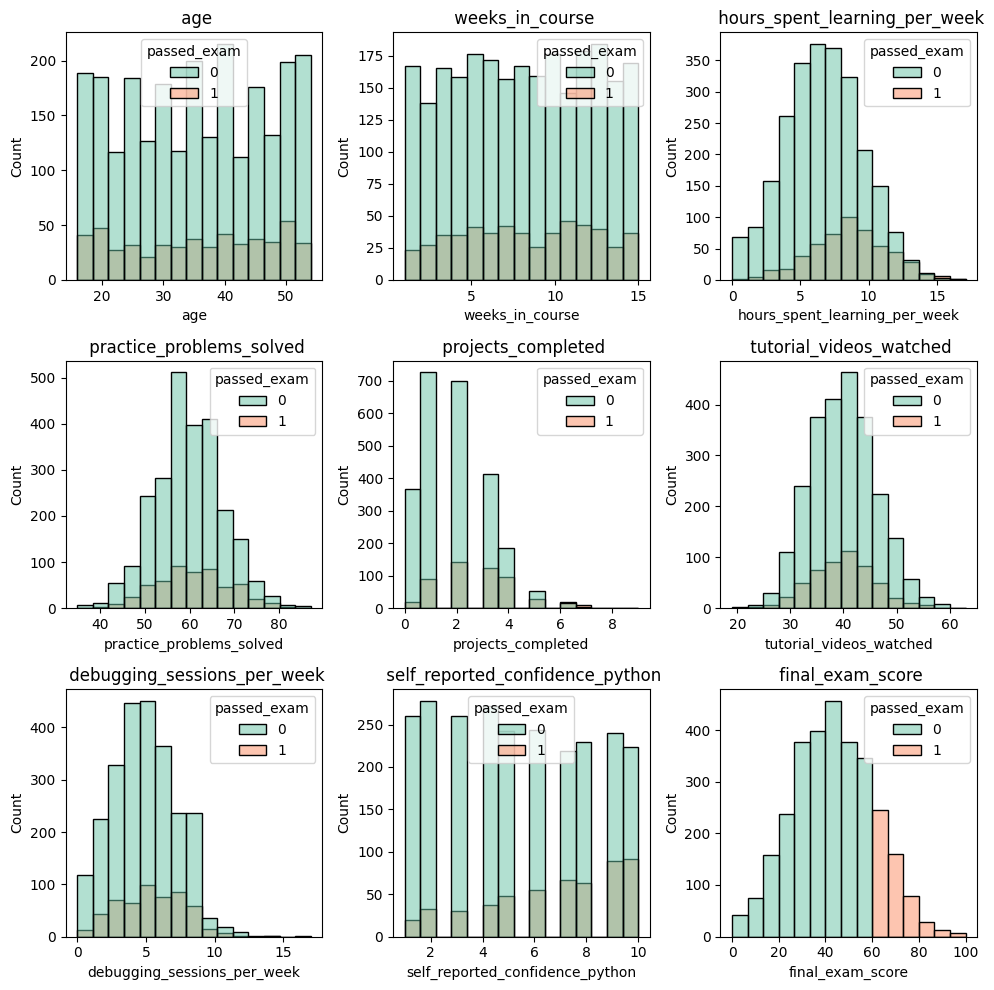

In [11]:
histplot_df(df, var_num, "passed_exam")
#Pareciera que hay 3 variables que tienen leves diferencias con el target: hours_spent_learning_per_week, projects_completed, self_reported_confidence_python
#La variable final exam_score CLARAMENTE divide los resultados de aprobado y no aprobado por lo que no se debe utilizar para entrenar el modelo, dado que es informacion posterior al examen

<Axes: >

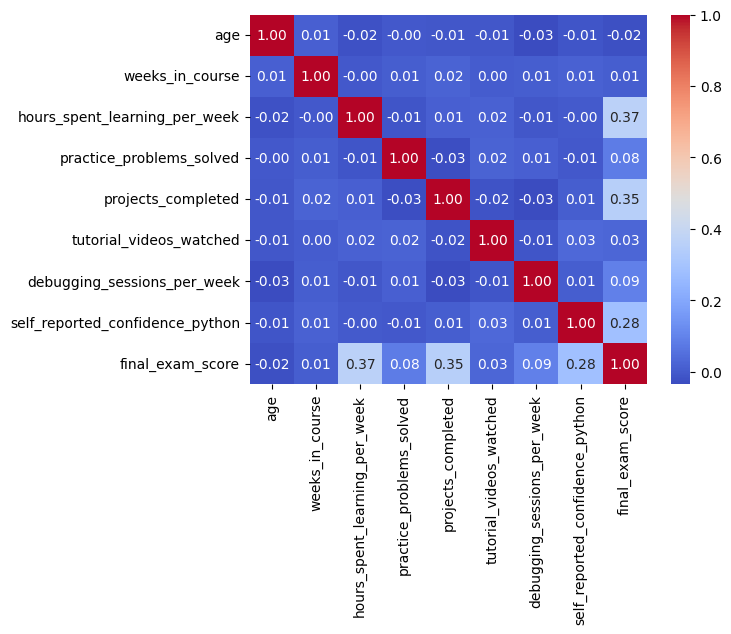

In [12]:
sns.heatmap(df[var_num].corr(), annot= True,
            fmt = ".2f",
            cmap = "coolwarm")
#Esto confirma que las 3 variables mencionadas anteriormente tienen la mayor relacion con pasar o no el examen

### Variables categorica: Country

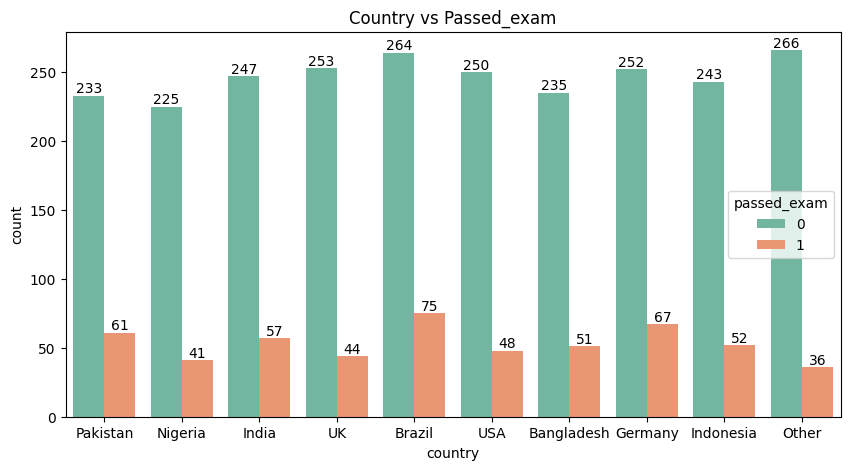

In [13]:
fig, ax = plt.subplots(figsize = (10,5))

sns.countplot(df, x = "country", hue = "passed_exam")
ax.set_title("Country vs Passed_exam")
for  p in ax.patches:
    alto = p.get_height()
    centro = p.get_x() + p.get_width()/2
    if alto != 0 and centro != 0:
        ax.annotate(
            int(alto),
            (centro,alto),
            ha = "center",
            va = "bottom"
        )

Text(5, 60, 'No se ve una difeencia marcada por país')

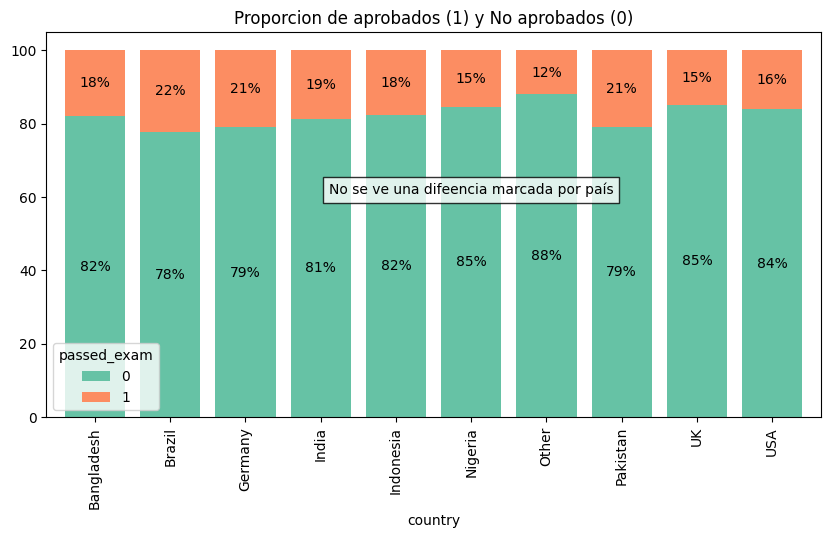

In [14]:
fig, ax = plt.subplots(figsize = (10,5))
tabla = pd.crosstab(df["country"], df["passed_exam"], normalize = "index")*100
tabla.plot(kind = "bar", stacked = True, width = 0.8, ax = ax)

ax.set_title("Proporcion de aprobados (1) y No aprobados (0)")

for c in ax.containers:
    ax.bar_label(c, fmt='%.0f%%', label_type='center')

ax.annotate("No se ve una difeencia marcada por país", xy= (5,60), ha = "center", va = "bottom", bbox={"alpha": 0.8,
                                                                                                       "facecolor": "white"})


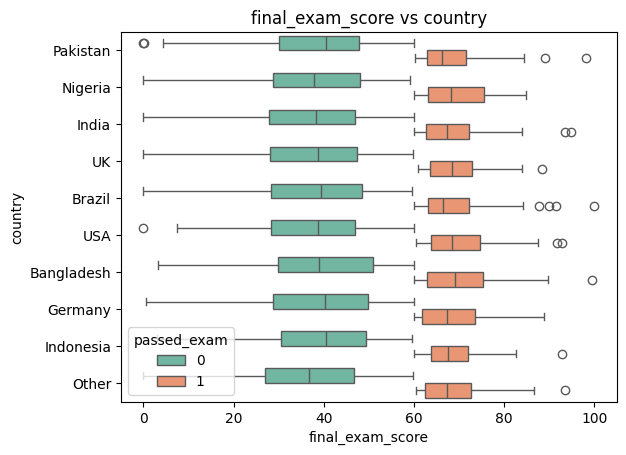

In [15]:
sns.boxplot(df, y = "country", x = "final_exam_score", hue = "passed_exam")
plt.title("final_exam_score vs country")
plt.show()

### Zoom a variables especificas

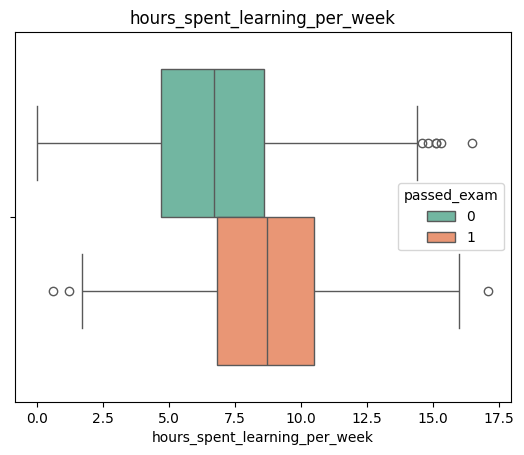

In [16]:
sns.boxplot(df, x = "hours_spent_learning_per_week", hue = "passed_exam")
plt.title("hours_spent_learning_per_week")
plt.show()
#Valores levemente desplazados entre clases del target

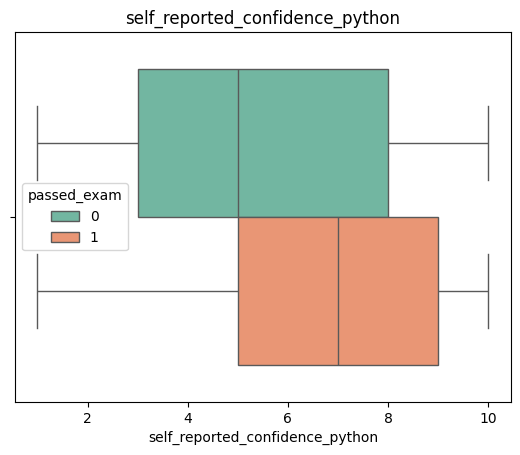

In [17]:
sns.boxplot(df, x = "self_reported_confidence_python", hue = "passed_exam")
plt.title("self_reported_confidence_python")
plt.show()
#Valores levemente desplazados entre clases del target

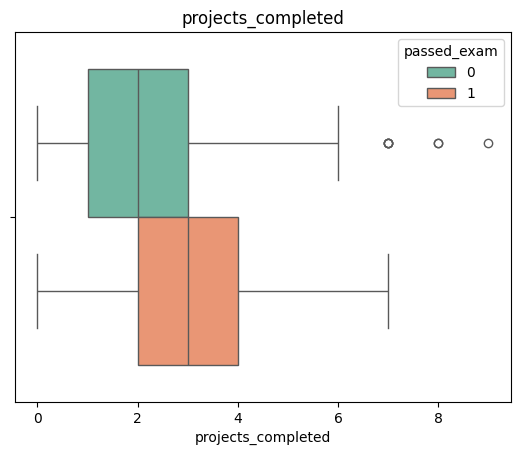

In [18]:
sns.boxplot(df, x = "projects_completed", hue = "passed_exam")
plt.title("projects_completed")
plt.show()
#Valores levemente desplazados entre clases del target

## Modelado

### Con todas las variables

In [21]:
drop_cols = ["prior_programming_experience", "student_id", "final_exam_score"] #Columnas a eliminar

num_var = make_column_selector(dtype_include="number")
cat_var = make_column_selector(dtype_include="object")

pipe_drop = FunctionTransformer(
        lambda x : x.drop(drop_cols, axis =1, errors = "ignore")
                                )

pipe_num = Pipeline(steps = [("imp_num", SimpleImputer(strategy = "median"))])

pipe_cat = Pipeline(steps = [("imp_cat", SimpleImputer(strategy="most_frequent")),
                             ("ohe", OneHotEncoder())])

pp = ColumnTransformer( transformers= [("num", pipe_num, num_var),
                                            ("cat", pipe_cat, cat_var)],
                                         remainder = "passthrough"
                                )

pipe_classifier = {
    
    "LogisticRegression" : {

        "model": LogisticRegression(),
        "params": {"classifier__C": [0.1,1,10],
                   "classifier__random_state" : [42],
                   #"selector__k": [4, 6, 8],

                   }
    },

    "DecisionTree" : {

        "model" : DecisionTreeClassifier(),
        "params": {"classifier__max_depth": [1,2,3,4],
                   "classifier__criterion": ["gini"],
                   "classifier__random_state" : [42],
                   #"selector__k": [4, 6, 8],
                   }

    },

    "RandomForest" : {

        "model": RandomForestClassifier(),
        "params": {"classifier__n_estimators": [100, 200,300, 400, 500],
                   "classifier__random_state" : [42],
                   #"selector__k": [4, 6, 8],
                   }

    },

    "XGBoost" : {

        "model": XGBClassifier(),
        "params": {"classifier__n_estimators": [100, 200,300, 400, 500],
                   "classifier__learning_rate" : [0.01, 0.02, 0.03],
                   "classifier__random_state" : [42],
                   #"selector__k": [4, 6, 8],
                   }
    },

}

target = "passed_exam"

df_x = df.drop(target, axis = 1)
df_y = df[target]

x_train, x_test , y_train, y_test = train_test_split(df_x, df_y, test_size= 0.5, random_state= 7)

mejor_modelo = {}

for name, modelo_data in pipe_classifier.items():
    pipe_final = Pipeline( steps = [
        ("drop", pipe_drop),
        ("preprocessor",  pp),
        #("selector", SelectKBest(score_func=f_classif)),
        ("classifier", modelo_data["model"])
    ])

    grid = GridSearchCV(pipe_final, modelo_data["params"], scoring = "accuracy", cv = 5)
    grid.fit(x_train, y_train)

    mejor_modelo[name] = {"mejor_accuracy" : grid.best_score_, #Selecciona el maximo accuracy
                          "mejores_parametros": grid.best_params_, #Seleciona los mejores parametros del modelo elegido
                          "mejor_estimator": grid.best_estimator_} #Selecciona el mejor pipeline
    
    print(f"{name} optimizado con Accuracy: {grid.best_score_:.4f}")

ganador = max(mejor_modelo, key=lambda x: mejor_modelo[x]['mejor_accuracy'])

print(f"El mejor modelo es {ganador}")

LogisticRegression optimizado con Accuracy: 0.8253
DecisionTree optimizado con Accuracy: 0.8193
RandomForest optimizado con Accuracy: 0.8333
XGBoost optimizado con Accuracy: 0.8247
El mejor modelo es RandomForest


In [22]:
mejor_pipeline = mejor_modelo[ganador]["mejor_estimator"]
mejor_pipeline

Pipeline(steps=[('drop',
                 FunctionTransformer(func=<function <lambda> at 0x000001CEE5A465C0>)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imp_num',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CEE48560F0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imp_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CEE3029D60>)])),
                ('classifier',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

In [23]:
nombres_tras_pp = mejor_pipeline.named_steps["preprocessor"].get_feature_names_out()
classifier = mejor_pipeline.named_steps['classifier']
importances = pd.Series(classifier.feature_importances_, index=nombres_tras_pp)
importances_sorted = importances.sort_values(ascending=False)

print("Importancia de las variables en Random Forest:")

print(importances_sorted)

Importancia de las variables en Random Forest:
num__hours_spent_learning_per_week        0.173148
num__practice_problems_solved             0.113486
num__age                                  0.103074
num__self_reported_confidence_python      0.097165
num__projects_completed                   0.097041
num__tutorial_videos_watched              0.094451
num__debugging_sessions_per_week          0.081980
num__weeks_in_course                      0.079615
num__participates_in_discussion_forums    0.022808
num__uses_kaggle                          0.021247
cat__country_Germany                      0.015680
cat__country_Brazil                       0.014557
cat__country_India                        0.012891
cat__country_USA                          0.011946
cat__country_Bangladesh                   0.011866
cat__country_Pakistan                     0.010582
cat__country_Indonesia                    0.010251
cat__country_Other                        0.009655
cat__country_UK                    

In [24]:
x_test_preprocessed = mejor_pipeline.named_steps['drop'].transform(x_test)
x_test_preprocessed = mejor_pipeline.named_steps['preprocessor'].transform(x_test_preprocessed)
x_test_final = pd.DataFrame(x_test_preprocessed, columns = mejor_pipeline.named_steps["preprocessor"].get_feature_names_out())

In [25]:
top_16_features  = importances_sorted[:16]
top_16_features

num__hours_spent_learning_per_week        0.173148
num__practice_problems_solved             0.113486
num__age                                  0.103074
num__self_reported_confidence_python      0.097165
num__projects_completed                   0.097041
num__tutorial_videos_watched              0.094451
num__debugging_sessions_per_week          0.081980
num__weeks_in_course                      0.079615
num__participates_in_discussion_forums    0.022808
num__uses_kaggle                          0.021247
cat__country_Germany                      0.015680
cat__country_Brazil                       0.014557
cat__country_India                        0.012891
cat__country_USA                          0.011946
cat__country_Bangladesh                   0.011866
cat__country_Pakistan                     0.010582
dtype: float64

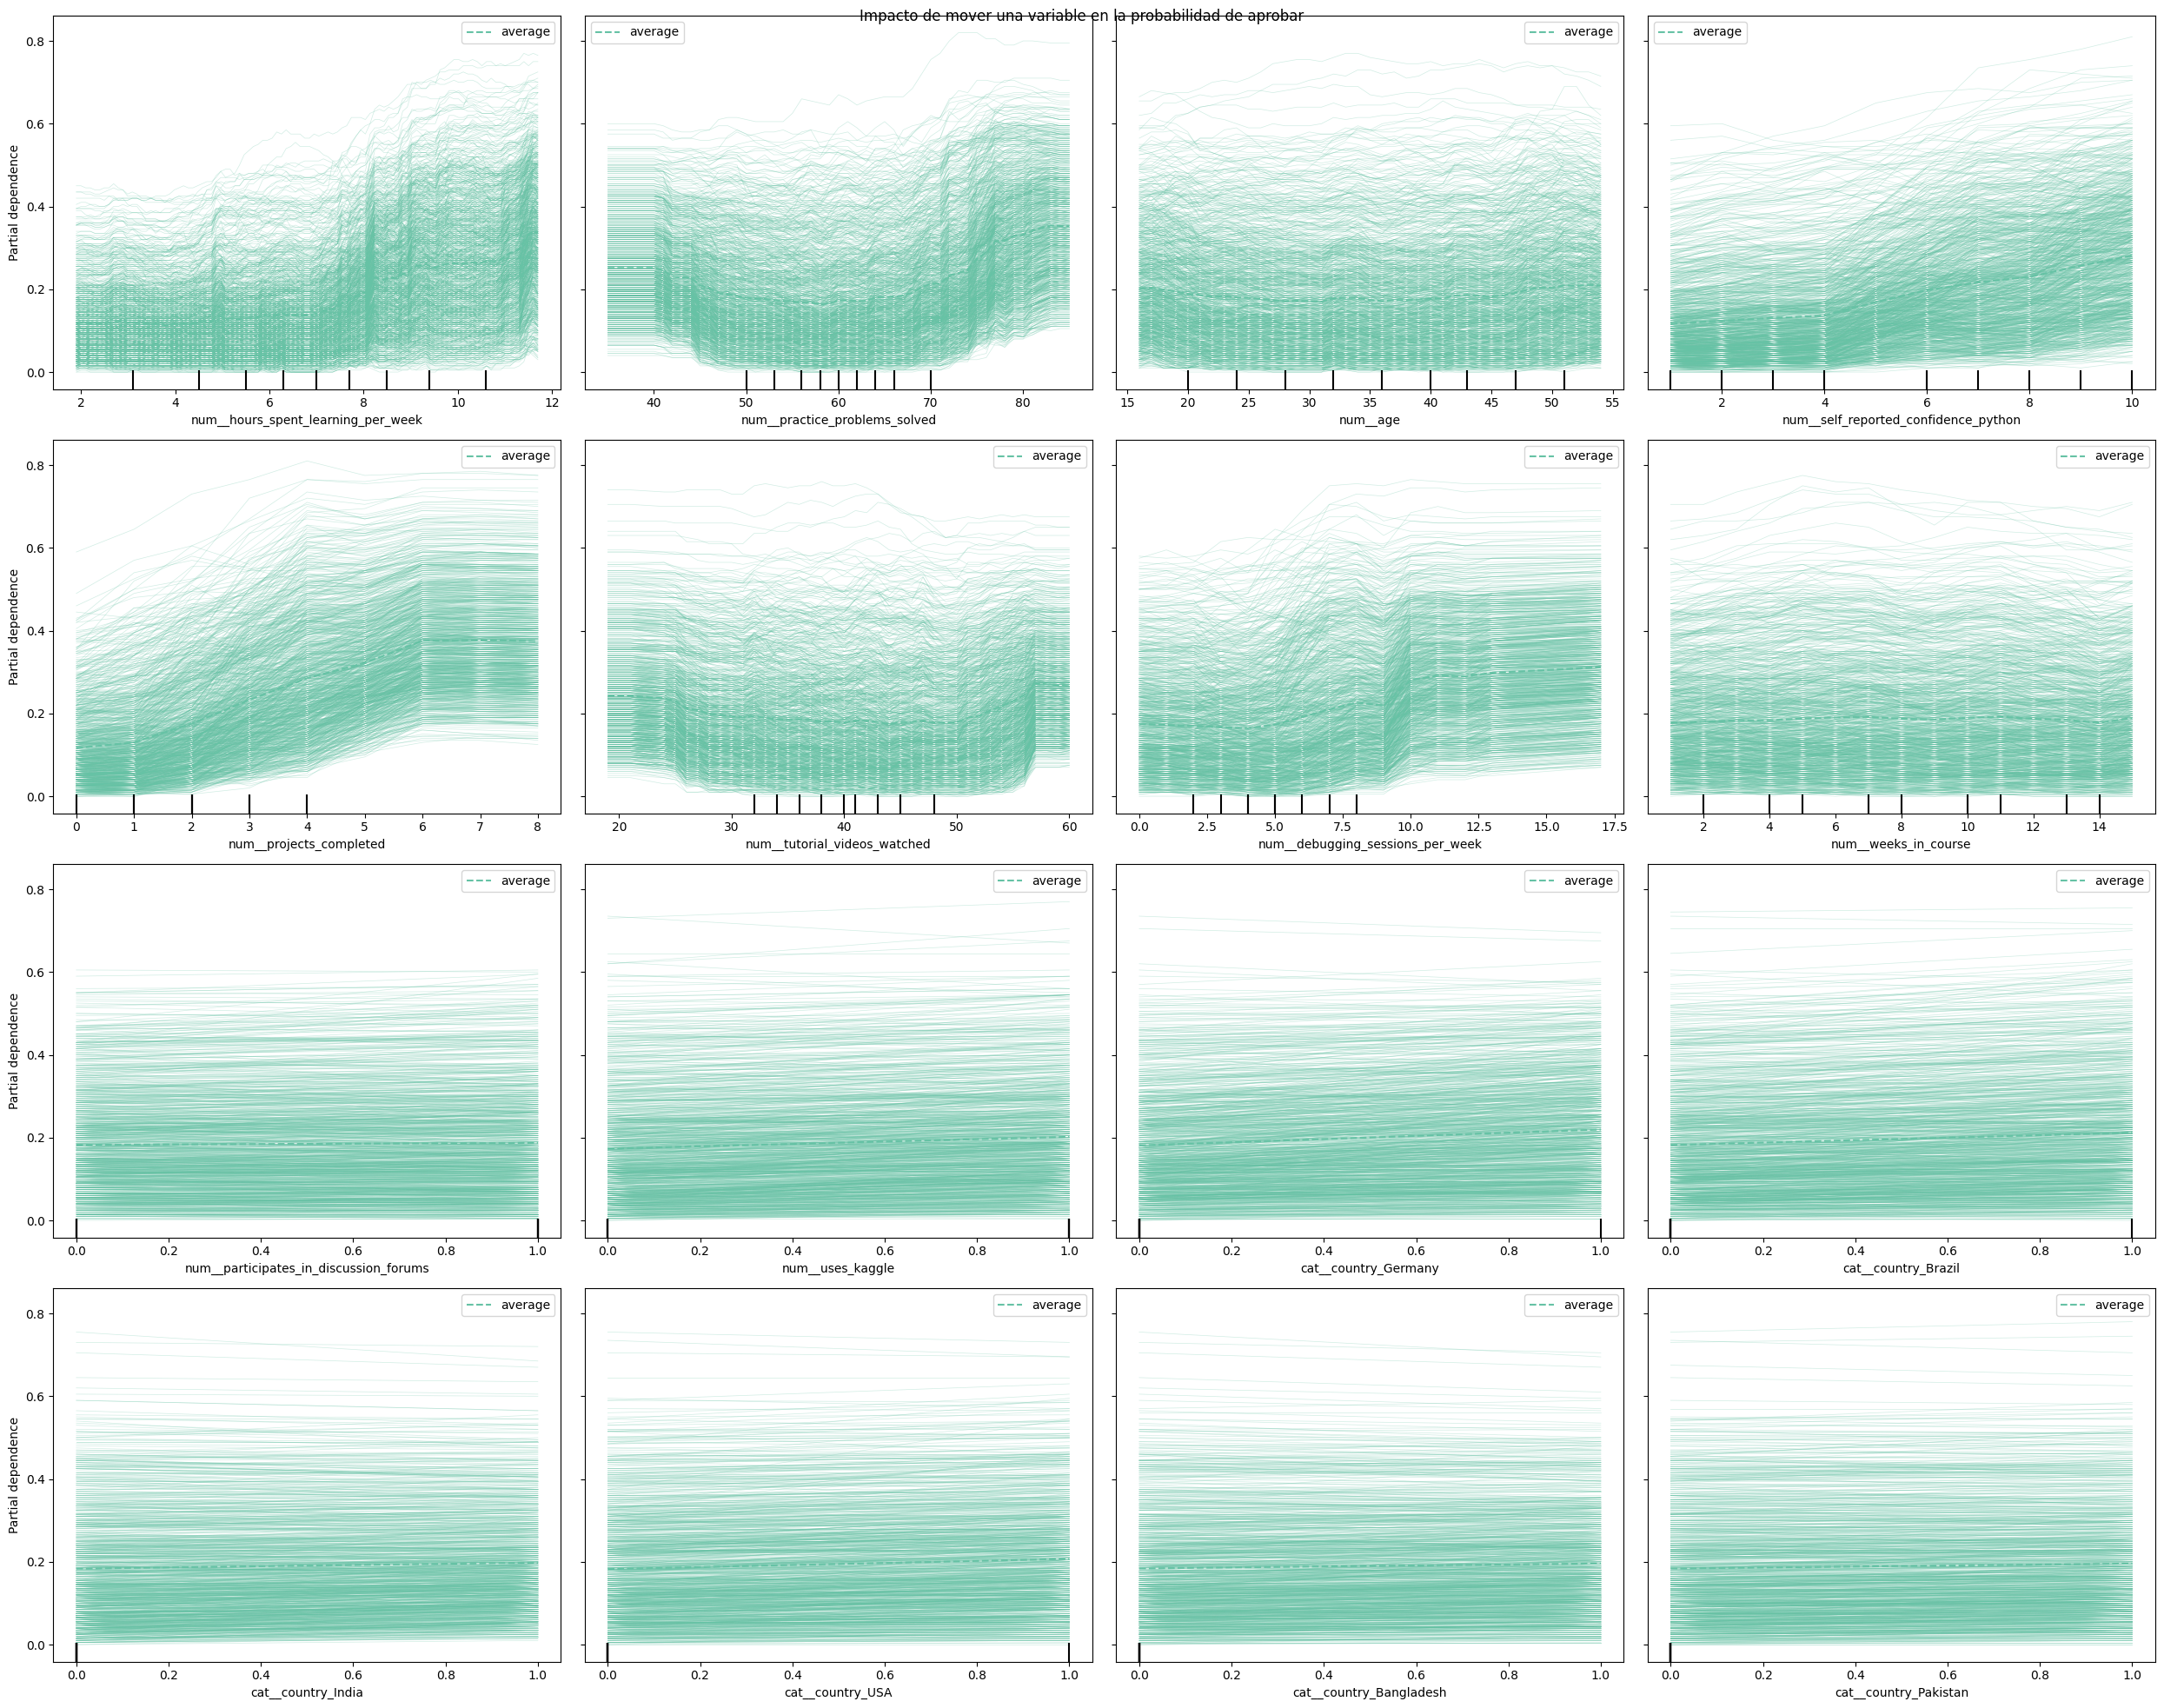

In [26]:

# 3. Graficar el impacto
fig, ax = plt.subplots(4,4,figsize=(25, 20))
display = PartialDependenceDisplay.from_estimator(
    mejor_pipeline.named_steps['classifier'], # El modelo final
    x_test_final,   # Solo las variables que pasaron el selector
    features = list(top_16_features.index), #Solo
    kind="both", # "average" para la tendencia global, "individual" para ver variaciones
    ax=ax
)



plt.suptitle('Impacto de mover una variable en la probabilidad de aprobar')
plt.tight_layout()
plt.show()

### Limitando variables

In [27]:
drop_cols = ["prior_programming_experience", "student_id", "final_exam_score"] #Columnas a eliminar

num_var = make_column_selector(dtype_include="number")
cat_var = make_column_selector(dtype_include="object")

pipe_drop = FunctionTransformer(
        lambda x : x.drop(drop_cols, axis =1, errors = "ignore")
                                )

pipe_num = Pipeline(steps = [("imp_num", SimpleImputer(strategy = "median"))])

pipe_cat = Pipeline(steps = [("imp_cat", SimpleImputer(strategy="most_frequent")),
                             ("ohe", OneHotEncoder())])

pp = ColumnTransformer( transformers= [("num", pipe_num, num_var),
                                            ("cat", pipe_cat, cat_var)],
                                         remainder = "passthrough"
                                )

pipe_classifier = {
    
    "LogisticRegression" : {

        "model": LogisticRegression(),
        "params": {"classifier__C": [0.1,1,10],
                   "classifier__random_state" : [42],
                   "selector__k": [4, 6, 8],

                   }
    },

    "DecisionTree" : {

        "model" : DecisionTreeClassifier(),
        "params": {"classifier__max_depth": [1,2,3,4],
                   "classifier__criterion": ["gini"],
                   "classifier__random_state" : [42],
                   "selector__k": [4, 6, 8],
                   }

    },

    "RandomForest" : {

        "model": RandomForestClassifier(),
        "params": {"classifier__n_estimators": [100, 200,300, 400, 500],
                   "classifier__random_state" : [42],
                   "selector__k": [4, 6, 8],
                   }

    },

    "XGBoost" : {

        "model": XGBClassifier(),
        "params": {"classifier__n_estimators": [100, 200,300, 400, 500],
                   "classifier__learning_rate" : [0.01, 0.02, 0.03],
                   "classifier__random_state" : [42],
                   "selector__k": [4, 6, 8],
                   }
    },

}

target = "passed_exam"

df_x = df.drop(target, axis = 1)
df_y = df[target]

x_train, x_test , y_train, y_test = train_test_split(df_x, df_y, test_size= 0.5, random_state= 7)

mejor_modelo = {}

for name, modelo_data in pipe_classifier.items():
    pipe_final = Pipeline( steps = [
        ("drop", pipe_drop),
        ("preprocessor",  pp),
        ("selector", SelectKBest(score_func=f_classif)),
        ("classifier", modelo_data["model"])
    ])

    grid = GridSearchCV(pipe_final, modelo_data["params"], scoring = "accuracy", cv = 5)
    grid.fit(x_train, y_train)

    mejor_modelo[name] = {"mejor_accuracy" : grid.best_score_,
                          "mejores_parametros": grid.best_params_,
                          "mejor_estimator": grid.best_estimator_}
    
    print(f"{name} optimizado con Accuracy: {grid.best_score_:.4f}")

ganador = max(mejor_modelo, key=lambda x: mejor_modelo[x]['mejor_accuracy'])

print(f"El mejor modelo es {ganador}")

LogisticRegression optimizado con Accuracy: 0.8340
DecisionTree optimizado con Accuracy: 0.8193
RandomForest optimizado con Accuracy: 0.8227
XGBoost optimizado con Accuracy: 0.8260
El mejor modelo es LogisticRegression


In [28]:
best_pipe = mejor_modelo[ganador]["mejor_estimator"]

variables = best_pipe.named_steps["preprocessor"].get_feature_names_out()
filtro_var_selec = best_pipe.named_steps["selector"].get_support()

var_finales = variables[filtro_var_selec]

coefs = best_pipe.named_steps["classifier"].coef_.ravel()
intercepto = float(best_pipe.named_steps["classifier"].intercept_)


df_formula = pd.DataFrame({
    "feature": var_finales,
    "beta": coefs,
    "odds_ratio": np.exp(coefs)
}).sort_values("beta", key=np.abs, ascending=False)

print("Intercept (beta0):", intercepto)
print(df_formula.head(30))


terms = [f"{b:.6f} * {f}" for f, b in zip(var_finales, coefs)]
equation = "logit(p) = " + f"{intercepto:+.6f} + " + " + ".join(terms)
print()
print(equation)




Intercept (beta0): -6.850285723391525
                                feature      beta  odds_ratio
1               num__projects_completed  0.509729    1.664840
0    num__hours_spent_learning_per_week  0.272064    1.312671
3  num__self_reported_confidence_python  0.228691    1.256954
2      num__debugging_sessions_per_week  0.136903    1.146716

logit(p) = -6.850286 + 0.272064 * num__hours_spent_learning_per_week + 0.509729 * num__projects_completed + 0.136903 * num__debugging_sessions_per_week + 0.228691 * num__self_reported_confidence_python


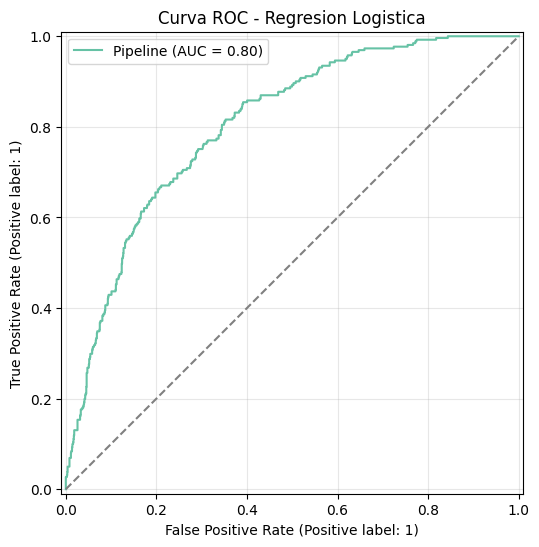

In [29]:

fig, ax = plt.subplots(figsize=(8, 6))


RocCurveDisplay.from_estimator(best_pipe, x_test, y_test, ax=ax)

# Añadir la línea base (un modelo que adivina al azar)
ax.plot([0, 1], [0, 1], linestyle="--", color="gray")

ax.set_title("Curva ROC - Regresion Logistica")
ax.legend()
plt.grid(alpha=0.3)
plt.show()